In [1]:
from sparta_tools import moria
mpath = "/Users/cosinga/sims/sparta_output/L0063_N0256_CBol/moria_trees/moria_tree_orb_defs.hdf5"
massdefs = ['M200m_all_spa', 'Morb-all_all_spa', 'Morb-all_orb_spa', 'Mvir_all_spa', 'Mpeak']
pids = ['parent_id_cat', 'parent_id_orbinf']
others = ['mask_alive', 'mask_cut', 'id']
redshifts = [0, 0.3, 0.5, 1, 1.5, 2, 4]
mconfig = moria.loadConfig(mpath)
mdata = moria.load(mpath, massdefs + pids + others)

In this notebook, I'm investigating why the Morb for host halos for both the ovd and orb subhalo definitions look nearly identical in the halo mass function of the lowest resolution simulation.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
snap_idx = np.argmin(np.abs(mconfig['simulation']['snap_z'] - 0))
alive = mdata['mask_alive'][snap_idx]
in_cut = mdata['mask_cut'][snap_idx]
orb_sub_mask = mdata[pids[1]][snap_idx, :] > 0
cat_sub_mask = mdata[pids[0]][snap_idx, :] > 0
print("total number of halos", mdata.shape[1])
print("total number of alive halos", np.sum(alive))
print("total number of halos in mass cut:", np.sum(in_cut))
print("total number of halos alive and in mass cut:", np.sum(in_cut & alive))
print()

print("number of subhalos with orb subhalo def:", np.sum(orb_sub_mask & alive & in_cut))
print("number of subhalos with cat subhalo def:", np.sum(cat_sub_mask & alive & in_cut))
print()

print("number of host halos with orb subhalo def:", np.sum(~orb_sub_mask & alive & in_cut))
print("number of host halos with cat subhalo def:", np.sum(~cat_sub_mask & alive & in_cut))
print()

print("host halo count difference:", np.sum(~orb_sub_mask & alive & in_cut) - np.sum(~cat_sub_mask & alive& in_cut))
print("subhalo count difference:", -1* np.sum(orb_sub_mask & alive& in_cut) + np.sum(cat_sub_mask & alive& in_cut))

total number of halos 38695
total number of alive halos 18277
total number of halos in mass cut: 18276
total number of halos alive and in mass cut: 18276

number of subhalos with orb subhalo def: 2240
number of subhalos with cat subhalo def: 3052

number of host halos with orb subhalo def: 16036
number of host halos with cat subhalo def: 15224

host halo count difference: 812
subhalo count difference: 812


The difference is the total number of halos that switched from parent to subhalo when using orbiting definition. However, not all of these halos have Morb at the current time (despite being alive?)

In [4]:

orb_host_mass = mdata[massdefs[1]][snap_idx, ~orb_sub_mask & alive]
cat_host_mass = mdata[massdefs[1]][snap_idx, ~cat_sub_mask & alive]
orb_pos_mass = orb_host_mass > 0
cat_pos_mass = cat_host_mass > 0
print('number of orb hosts with actual Morb', np.sum(orb_pos_mass))
print('number of catalog hosts with actual Morb', np.sum(cat_pos_mass))

print('number of ')
orb_min_mass = orb_host_mass > 1e10
cat_min_mass = cat_host_mass > 1e10

print('number of orb hosts with Morb on histogram', np.sum(orb_min_mass))
print('number of catalog hosts with Morb on histogram', np.sum(cat_min_mass))

number of orb hosts with actual Morb 7991
number of catalog hosts with actual Morb 7838
number of 
number of orb hosts with Morb on histogram 7990
number of catalog hosts with Morb on histogram 7838


About half of the host halos in either subhalo definition have Morb = 0 - and the reason why even the ~150 or so don't appear in the hmfs is not because they are outside the bounds of the histogram.

Let's create a mask of the halos that become hosts when using the orbiting subhalo definition for the next tests



In [5]:
sub_to_host_mask = ~orb_sub_mask & cat_sub_mask & alive
host_to_sub_mask = ~cat_sub_mask & orb_sub_mask & alive
print("catalog subhalos that are not orbiting (cat subhalos -> orb halos)", np.sum(sub_to_host_mask))
print("catalog halos that are orbiting other halos (cat halos -> orb subhalos)", np.sum(host_to_sub_mask))
print("difference:", abs(np.sum(sub_to_host_mask) - np.sum(host_to_sub_mask)))


catalog subhalos that are not orbiting (cat subhalos -> orb halos) 1315
catalog halos that are orbiting other halos (cat halos -> orb subhalos) 503
difference: 812


In [6]:
morb = mdata[massdefs[1]][snap_idx, :]
pos_morb_mask = mdata[massdefs[1]][snap_idx, :] > 0

print("catalog subhalos that are not orbiting (cat subhalos -> orb halos) with Morb > 0", np.sum(sub_to_host_mask & pos_morb_mask))
print("catalog halos that are orbiting other halos (cat halos -> orb subhalos) with Morb > 0", np.sum(host_to_sub_mask & pos_morb_mask))
print("difference:", abs(np.sum(sub_to_host_mask & pos_morb_mask) - np.sum(host_to_sub_mask & pos_morb_mask)))


catalog subhalos that are not orbiting (cat subhalos -> orb halos) with Morb > 0 656
catalog halos that are orbiting other halos (cat halos -> orb subhalos) with Morb > 0 503
difference: 153


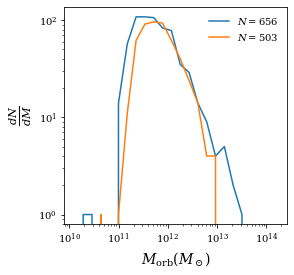

In [11]:
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'serif'
sth_morb = morb[sub_to_host_mask & pos_morb_mask]
hts_morb = morb[host_to_sub_mask & pos_morb_mask]
bins = np.geomspace(1e10, 2e14, 25)
sth_hist, edges = np.histogram(sth_morb, bins)
hts_hist, edges = np.histogram(hts_morb, bins)
mid = (edges[1:] + edges[:-1]) / 2
fig = plt.figure(figsize = (4,4))
plt.plot(mid, sth_hist, label = '$N = %d$'%np.sum(sub_to_host_mask & pos_morb_mask))
plt.plot(mid, hts_hist, label = '$N = %d$'%np.sum(host_to_sub_mask & pos_morb_mask))
plt.legend(frameon = False, loc = 'upper right')
plt.loglog()
plt.xlabel('$M_{\\mathrm{orb}} (M_\\odot)$', fontsize = 14)
plt.ylabel('$\\frac{dN}{dM}$', fontsize = 16)
plt.savefig("/Users/cosinga/overleaf/proposal_defense/figures/switching_populations_morb.png", dpi = 150, bbox_inches = 'tight')

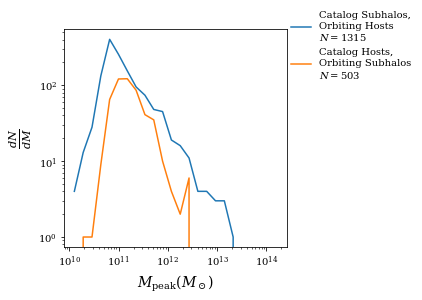

In [8]:
mpeak = mdata[massdefs[-1]][snap_idx, :]
pos_mpeak_mask = mpeak > 0
sth_mpeak = mpeak[sub_to_host_mask & pos_mpeak_mask]
hts_mpeak = mpeak[host_to_sub_mask & pos_mpeak_mask]
bins = np.geomspace(1e10, 2e14, 25)
sth_hist, edges = np.histogram(sth_mpeak, bins)
hts_hist, edges = np.histogram(hts_mpeak, bins)
mid = (edges[1:] + edges[:-1]) / 2
fig = plt.figure(figsize = (4,4))
plt.plot(mid, sth_hist, label = 'Catalog Subhalos,\nOrbiting Hosts\n$N = %d$'%np.sum(sub_to_host_mask & pos_mpeak_mask))
plt.plot(mid, hts_hist, label = 'Catalog Hosts,\nOrbiting Subhalos\n$N = %d$'%np.sum(host_to_sub_mask & pos_mpeak_mask))
plt.legend(frameon = False, loc = (1, 0.75))
plt.loglog()
plt.xlabel('$M_{\\mathrm{peak}} (M_\\odot)$', fontsize = 14)
plt.ylabel('$\\frac{dN}{dM}$', fontsize = 16)
plt.savefig("/Users/cosinga/overleaf/proposal_defense/figures/switching_populations_mpeak.png", dpi = 150, bbox_inches = 'tight')

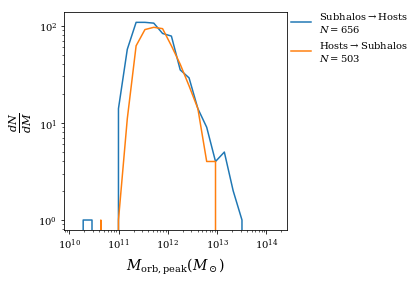

In [100]:
morb = mdata[massdefs[1]]
morb_peak = np.maximum.accumulate(morb, axis = 0)
morb_peak = morb_peak[snap_idx, :]
pos_mpeak_mask = morb_peak > 0
sth_mpeak = morb_peak[sub_to_host_mask & pos_mpeak_mask]
hts_mpeak = morb_peak[host_to_sub_mask & pos_mpeak_mask]
bins = np.geomspace(1e10, 2e14, 25)
sth_hist, edges = np.histogram(sth_mpeak, bins)
hts_hist, edges = np.histogram(hts_mpeak, bins)
mid = (edges[1:] + edges[:-1]) / 2
fig = plt.figure(figsize = (4,4))
plt.plot(mid, sth_hist, label = 'Subhalos$\\rightarrow$Hosts\n$N = %d$'%np.sum(sub_to_host_mask & pos_mpeak_mask))
plt.plot(mid, hts_hist, label = 'Hosts$\\rightarrow$Subhalos\n$N = %d$'%np.sum(host_to_sub_mask & pos_mpeak_mask))
plt.legend(frameon = False, loc = (1, 0.75))
plt.loglog()
plt.xlabel('$M_{\\mathrm{orb, peak}} (M_\\odot)$', fontsize = 14)
plt.ylabel('$\\frac{dN}{dM}$', fontsize = 16)
plt.savefig("/Users/cosinga/overleaf/proposal_defense/figures/switching_populations_morb_peak.png", dpi = 150, bbox_inches = 'tight')


In [27]:
peak[snap_idx, ~orb_sub_mask & alive & ~pos_mass]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)